In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch.serialization import default_restore_location

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

In [2]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Load the GAN model

In [3]:
restore_file= "experiments/unet1d/unet1d-Aug-30-14:24:33/checkpoints/checkpoint_last.pt"
# load state_dict for args
state_dict = torch.load(restore_file, map_location=lambda s, l: default_restore_location(s, "cpu"))
# Extract args
args = state_dict['args']

In [4]:
G,D = models.build_model_gan(args)
netG = G.to(device)
netD = D.to(device)

# 2 optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=args.lr,betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=args.lr,betas=(0.5, 0.999))

state_dict = utils.load_checkpoint_GAN(args, netG, netD, optimizerG, optimizerD)

### Load the MSE model

In [6]:
# Load MSE model
mse = models.build_model(args)
netMSE = mse.to(device)

MODEL_PATH = "models/trained/unet1d_partialconv_10kdata_30epoch_3minsep_08_14_20.pth"
netMSE.load_state_dict(torch.load(MODEL_PATH))
netMSE.to(device)

UNet(
  (conv1): PartialConv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (conv2): PartialConv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): PartialConv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
  (conv4): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv5): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
  (conv6): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
  (conv7): ConvTranspose1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  (conv8): PartialConv1d(96, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv9): PartialConv1d(32, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
)

### Testing

In [5]:
# Best PSNR 28.560
def mask_idx_f(mask):
    mask_start = int(np.argmin(mask[0]))
    mask_length = int((1-mask[0]).sum())
    mask_idx = range(mask_start,mask_start+mask_length)
     # No mask indices
    before = np.arange(mask.shape[2])[:mask_start]
    after = np.arange(mask.shape[2])[mask_start+mask_length:]
    no_mask_idx = np.append(before,after)
    return mask_idx,before, after, mask_length, mask_start

def print_one(loader,model1,model2):
    np.random.seed()
    clean,mask = next(iter(loader))
    outputs1 = model1(clean.to(device),mask.to(device)).cpu()
    outputs2 = model2(clean.to(device),mask.to(device)).cpu()
    
    mask_idx,before_mask,after_mask,mask_length, mask_start = mask_idx_f(mask)

    out1 = outputs1[0] * (1-mask[0]) + clean[0]*mask[0]
    out2 = outputs2[0] * (1-mask[0]) + clean[0]*mask[0]

    print("Mask Length: {}\tMask Start: {}".format(mask_length,mask_start))
    
    plt.figure(figsize=[15,14])
    plt.subplot(4,1,1)
    plt.plot(clean[0,0,:],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("True signal")

    plt.subplot(4,1,2)
    masked = clean[0]*mask[0]
    masked_plot = masked[:mask_start,]
    plt.plot(before_mask,masked[0,before_mask],'xb')
    plt.plot(after_mask,masked[0,after_mask],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("Masked signal")

    plt.subplot(4,1,3)
    plt.plot(out1[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("GAN denoised signal")
    print(outputs1[0,:].detach())
    
    plt.subplot(4,1,4)
    plt.plot(out2[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("MSE denoised signal")
#     return out1,out2, clean

In [7]:
# Test loader is shuffled and allows test_num to force a certain mask shape
_, _, test_loader = data.build_dataset(args.datasetG,
                                                   1000, 
                                                   batch_size=1,
                                                   fix_datapoints=False,
                                                   min_sep = args.min_sep,
                                                   test_num = 2)

Mask Length: 5	Mask Start: 20
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.4369e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 7.4328e-03, 2.9097e-05, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.5101e-03, 0.0000e+00]])


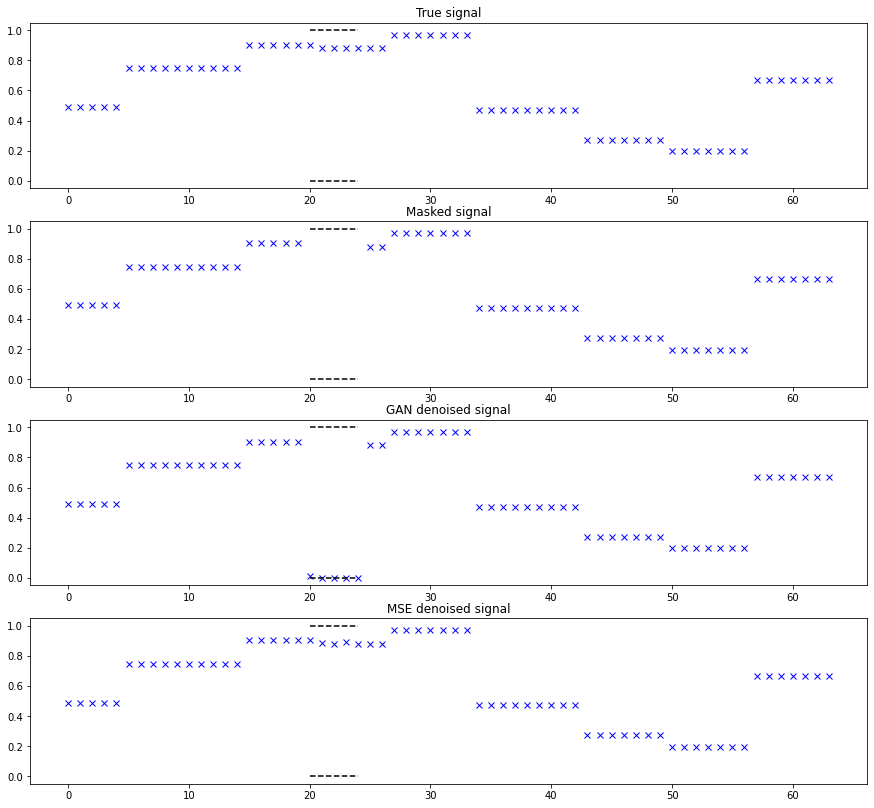

In [8]:
print_one(test_loader,netG,netMSE)

Mask Length: 7	Mask Start: 20
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0016, 0.0278, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0082, 0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0033,
         0.0000]])


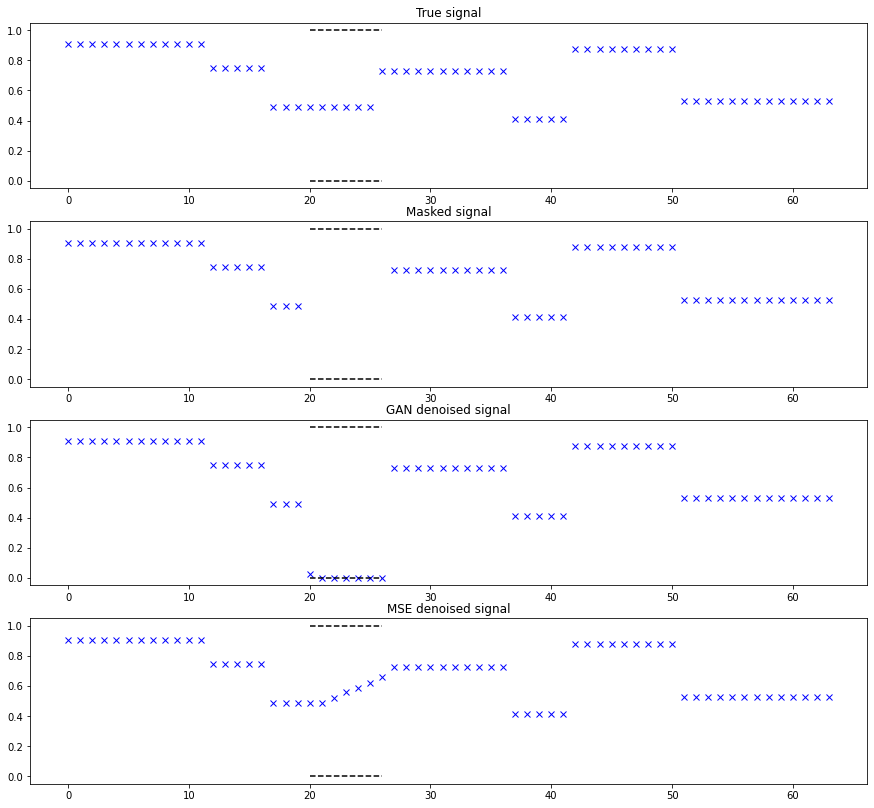

In [9]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
k=0
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.title("Generator Loss")
plt.ylabel("Error")
plt.xlabel("Total batch number")
plt.plot(G_losses[k:],'bx')

plt.subplot(2,1,2)
plt.title("Discriminator Loss")
plt.ylabel("Error")
plt.xlabel("Total batch number")
plt.plot(D_losses[k:],'rx')

In [ ]:
# ## Saving the model
# MODEL_PATHG = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
# MODEL_PATHD = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
# torch.save(netG.state_dict(), MODEL_PATHG)
# torch.save(netD.state_dict(), MODEL_PATHD)